In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb 
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('train.csv')

data.head(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2
6,0,1,0,0.000,0,2021-09-01 00:00:00,0,6,3
7,0,1,0,59.000,1,2021-09-01 00:00:00,0,7,3
8,0,1,1,0.000,0,2021-09-01 00:00:00,0,8,4
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4


In [3]:
data.duplicated().sum()

0

In [4]:
#shape of the data
data.shape

(2018352, 9)

In [5]:
#check if there is any null values
data.isnull().sum()/data.shape[0]*100

county                0.00000
is_business           0.00000
product_type          0.00000
target                0.02616
is_consumption        0.00000
datetime              0.00000
data_block_id         0.00000
row_id                0.00000
prediction_unit_id    0.00000
dtype: float64

In [6]:
#since the % of null value is negligible we ar deleteing it
data = data.dropna()

In [7]:
data.isnull().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [8]:
#info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 153.9+ MB


In [9]:
#here datetime is in object soo we need to change to datetime
data['datetime'] = pd.to_datetime(data['datetime'], utc = True)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype              
---  ------              -----              
 0   county              int64              
 1   is_business         int64              
 2   product_type        int64              
 3   target              float64            
 4   is_consumption      int64              
 5   datetime            datetime64[ns, UTC]
 6   data_block_id       int64              
 7   row_id              int64              
 8   prediction_unit_id  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(7)
memory usage: 153.9 MB


In [11]:
data['year'] = data['datetime'].dt.year

In [12]:
print("Start date: ",data['datetime'].min())

Start date:  2021-09-01 00:00:00+00:00


In [13]:
print("End date: ",data['datetime'].max())

End date:  2023-05-31 23:00:00+00:00


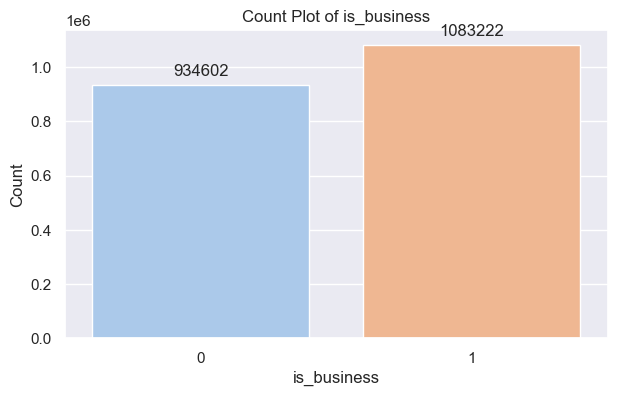

In [14]:
plt.figure(figsize=(7, 4))
sns.set_theme(style = "darkgrid")
ax = sns.countplot(data=data, x='is_business',palette = 'pastel')

# Annotate the bars with the count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

plt.title('Count Plot of is_business')
plt.xlabel('is_business')
plt.ylabel('Count')
plt.show()

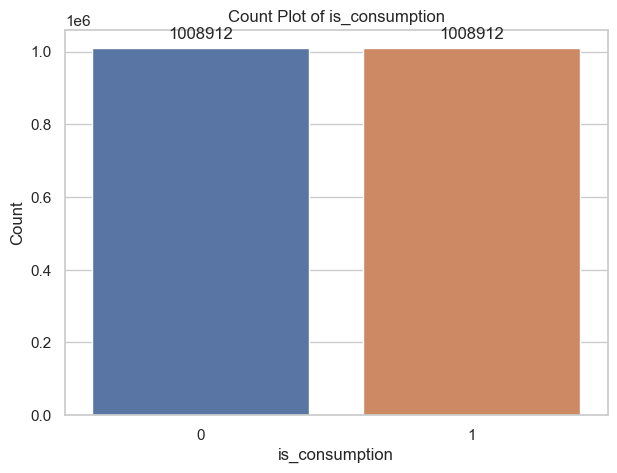

In [15]:
plt.figure(figsize=(7, 5))
sns.set_theme(style = "whitegrid")
ax = sns.countplot(data=data, x='is_consumption')

# Annotate the bars with the count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

plt.title('Count Plot of is_consumption')
plt.xlabel('is_consumption')
plt.ylabel('Count')
plt.show()

In [16]:
#pie chart for product type
value_counts = data['product_type'].value_counts()
value_counts

3    918480
1    781428
0    170500
2    147416
Name: product_type, dtype: int64

In [17]:
value_counts.index

Int64Index([3, 1, 0, 2], dtype='int64')

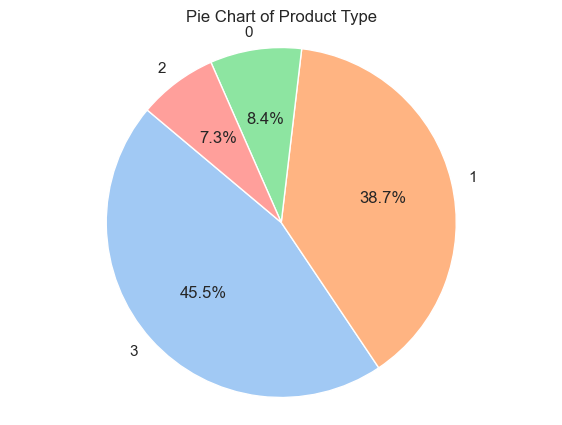

In [18]:
# Labels for the pie chart
labels = value_counts.index

# Values for the pie chart
sizes = value_counts.values

# Colors for the pie chart using seaborn color palette
colors = sns.color_palette('pastel', len(labels))

# Create a pie chart
plt.figure(figsize=(7,5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Product Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

<Axes: xlabel='county', ylabel='count'>

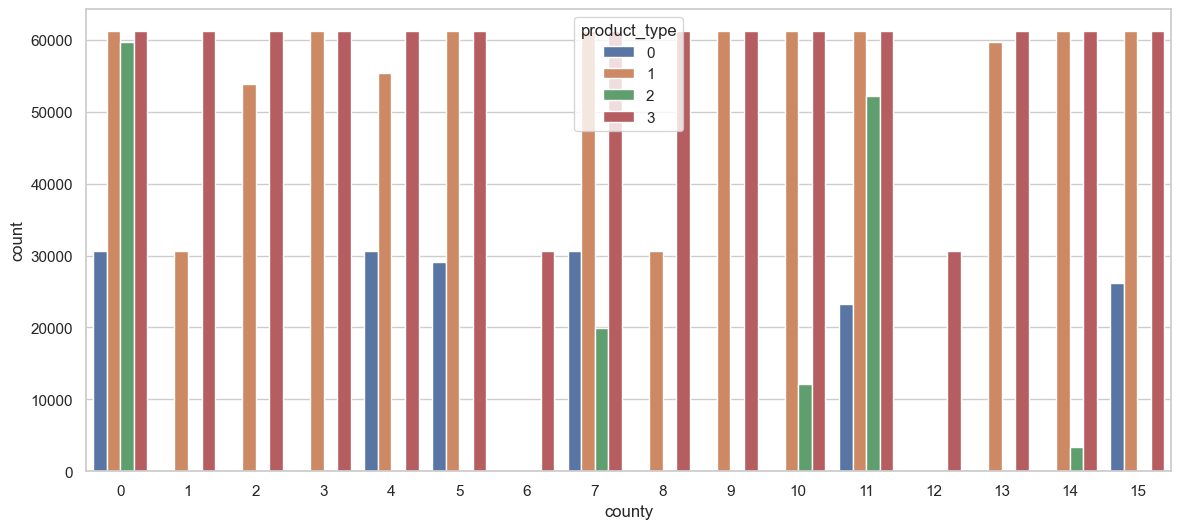

In [19]:
#plotting product type
plt.figure(figsize=(14, 6))
sns.countplot(data=data, x='county', hue='product_type')

We find that only county 0, 7 & 11 have all product types used.

county 6 and 12 only uses type 3.

We see that the product types 1 & 3 are used in all the counties, while type 2 and 0 are only used in few counties

<Axes: xlabel='is_business', ylabel='count'>

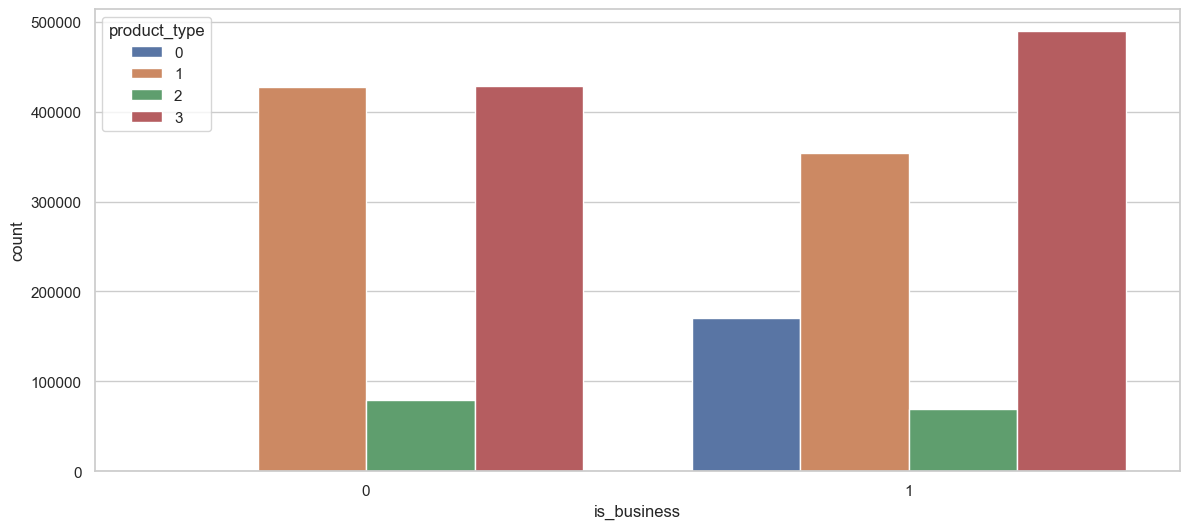

In [20]:
plt.figure(figsize=(14, 6))
sns.countplot(data=data, x='is_business', hue='product_type')

<Axes: xlabel='is_consumption', ylabel='count'>

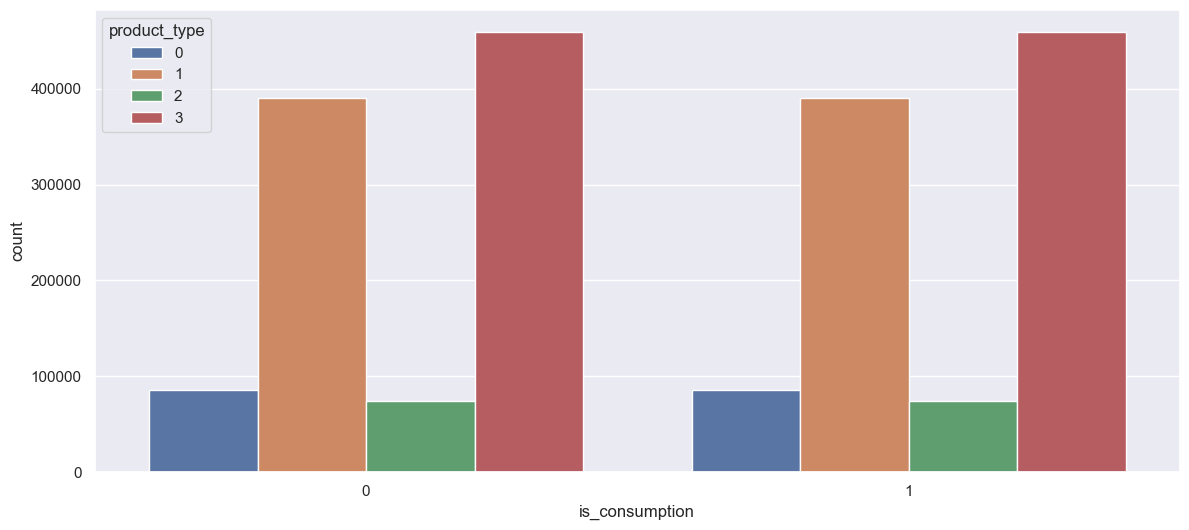

In [21]:
plt.figure(figsize=(14, 6))
sns.set_theme(style = "darkgrid")
sns.countplot(data=data, x='is_consumption', hue='product_type')

In [22]:
data.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,0,0,2021
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,1,0,2021
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,0,2,1,2021
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,0,3,1,2021
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,0,4,2,2021


In [23]:
grouped_data = data.groupby(['datetime','is_consumption'])['target'].mean().unstack().rename({0:'produced',1:'consumed'},axis = 1)

In [24]:
grouped_data

is_consumption,produced,consumed
datetime,,
2021-09-01 00:00:00+00:00,0.071508,325.570623
2021-09-01 01:00:00+00:00,0.194295,315.820951
2021-09-01 02:00:00+00:00,0.030246,315.752328
2021-09-01 03:00:00+00:00,0.024869,311.909574
2021-09-01 04:00:00+00:00,0.040852,317.493836
...,...,...
2023-05-31 19:00:00+00:00,174.322908,431.672446
2023-05-31 20:00:00+00:00,64.831000,474.340077
2023-05-31 21:00:00+00:00,13.178462,501.559800


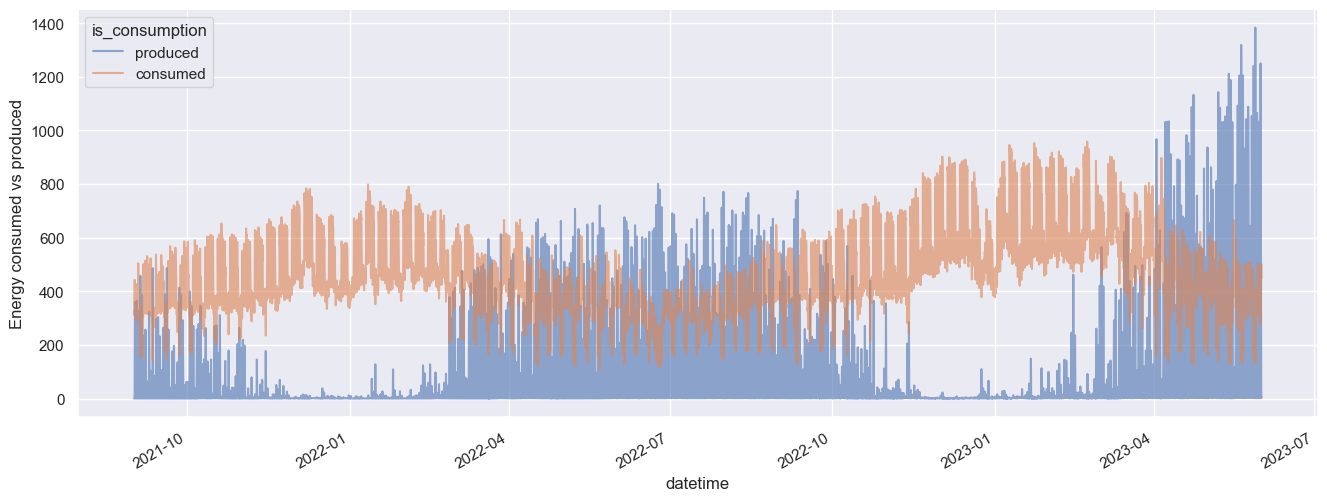

In [25]:
grouped_data.plot(figsize=(16, 6), alpha=0.6)
_ = plt.ylabel('Energy consumed vs produced')

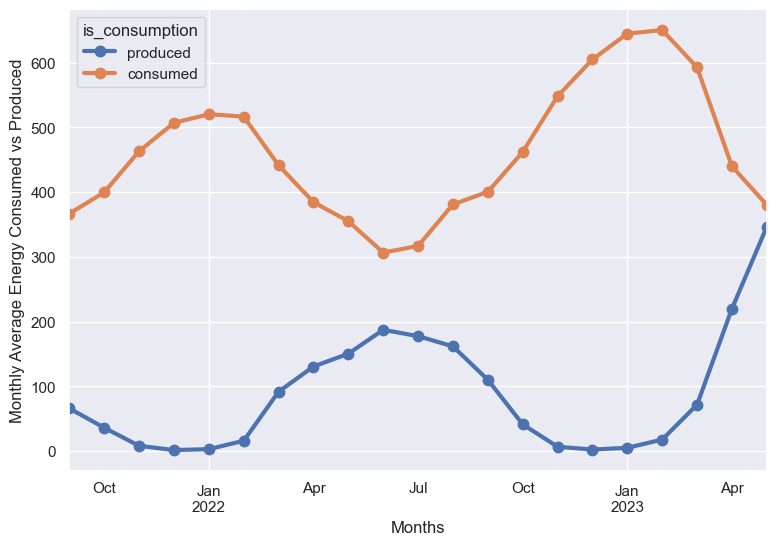

In [26]:
# plot of monthly average energy
grouped_data.resample('M').mean().plot(figsize=(9,6), linewidth=3, marker=".", markersize=15)
plt.xlabel("Months")
_ = plt.ylabel('Monthly Average Energy Consumed vs Produced')


n the two charts above, we notice a pattern in energy consumption and production. During the autumn/winter months (October-February), production goes down while consumption goes up. This can be explained by people and businesses using more energy for heating, and there is less sunlight during this time.

In contrast, during the spring/summer (March-September) months, the opposite happens. There is an increase in energy production due to higher temperatures (less need for heating) and more sunlight, leading to a decrease in energy consumption.

In [27]:
grouped_data

is_consumption,produced,consumed
datetime,,
2021-09-01 00:00:00+00:00,0.071508,325.570623
2021-09-01 01:00:00+00:00,0.194295,315.820951
2021-09-01 02:00:00+00:00,0.030246,315.752328
2021-09-01 03:00:00+00:00,0.024869,311.909574
2021-09-01 04:00:00+00:00,0.040852,317.493836
...,...,...
2023-05-31 19:00:00+00:00,174.322908,431.672446
2023-05-31 20:00:00+00:00,64.831000,474.340077
2023-05-31 21:00:00+00:00,13.178462,501.559800


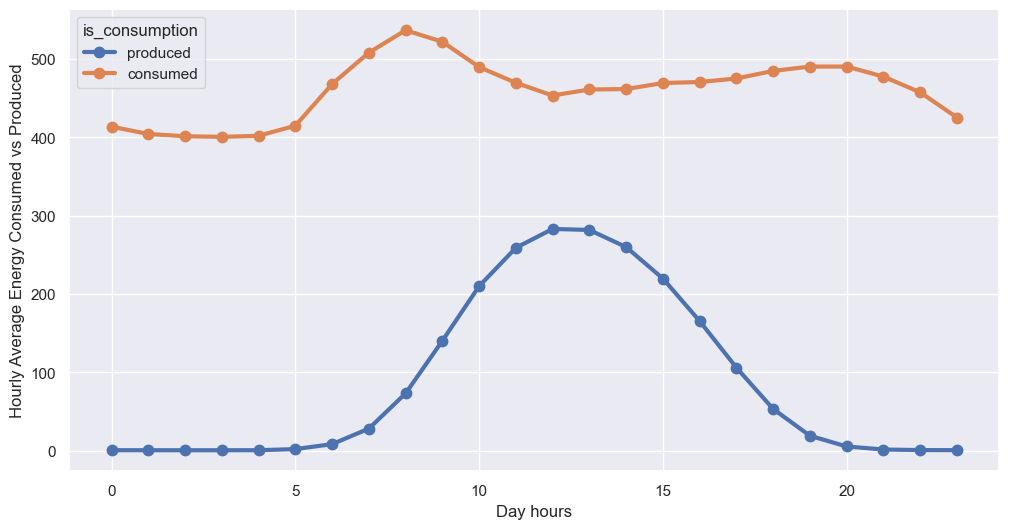

In [28]:
grouped_data.groupby(grouped_data.index.hour).mean().plot(figsize=(12, 6), linewidth=3, marker=".", markersize=15)
plt.xlabel("Day hours")
_ = plt.ylabel("Hourly Average Energy Consumed vs Produced")

In [29]:
y = grouped_data.groupby(grouped_data.index.hour).mean()
y 

is_consumption,produced,consumed
datetime,,
0,0.797357,413.649621
1,0.773396,404.259132
2,0.749598,401.376791
3,0.749179,400.598262
4,0.804984,401.945837
5,2.206292,414.769181
6,8.533921,467.915375
7,28.359547,507.964670
8,73.296150,536.598392


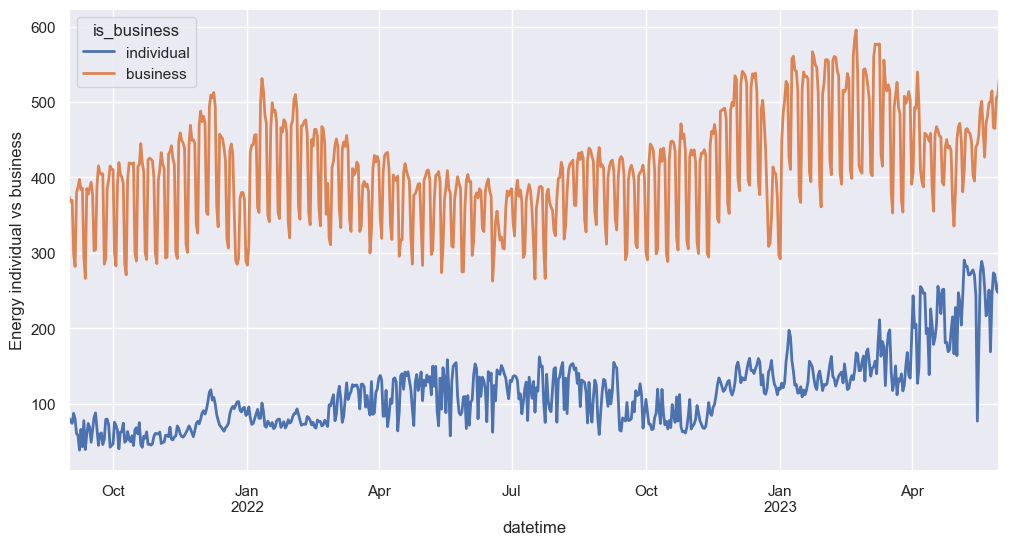

In [30]:
avg_target_business = data.groupby(['datetime','is_business'])['target'].mean() \
                       .unstack().rename({0: 'individual', 1:'business'}, axis=1)

avg_target_business.resample('D').mean().plot(figsize=(12,6), linewidth=2)
_ = plt.ylabel('Energy individual vs business')

The energy participation, whether it's consumption or production, is higher for businesses compared to individuals. This is expected because individuals typically generate power from their small rooftops and consume only enough energy for their own houses. On the other hand, businesses have larger facilities, including bigger rooftops in manufacturing factories, and they consume significantly more energy in their operations.

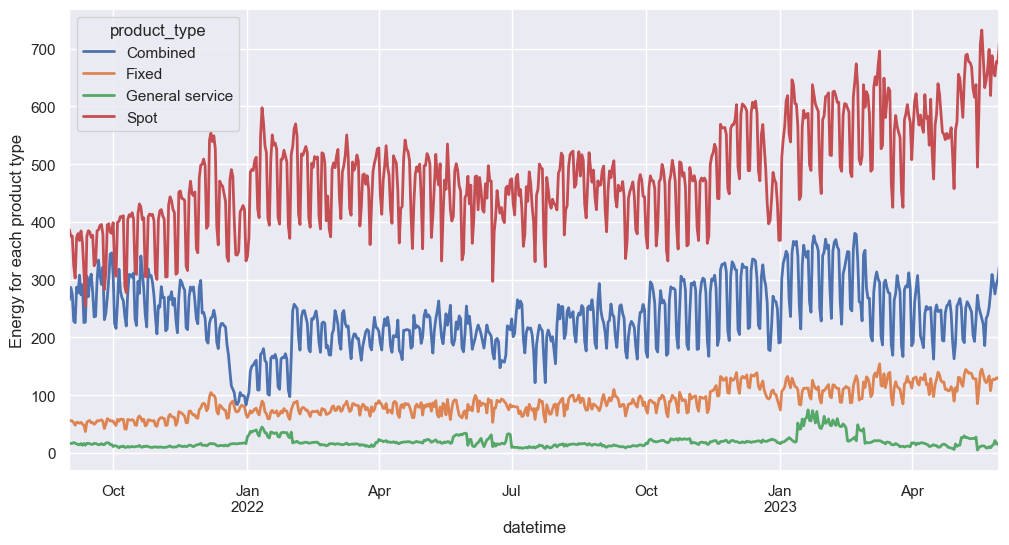

In [31]:
avg_target_product = data.groupby(['datetime','product_type'])['target'].mean()\
                       .unstack().rename({0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}, axis=1)

avg_target_product.resample('D').mean().plot(figsize=(12,6), linewidth=2)
_ = plt.ylabel('Energy for each product type')

In [32]:
data['date'] = data['datetime'].dt.date

In [33]:
# Aggregate the target by summing it
grouped_data_1 = data.groupby(['date', 'county', 'is_consumption', 'product_type', 'is_business']).agg({
    'target': 'sum'
}).reset_index()

grouped_data_1

,date,county,is_consumption,product_type,is_business,target
0,2021-09-01,0,0,0,1,714.600
1,2021-09-01,0,0,1,0,2797.045
2,2021-09-01,0,0,1,1,1621.027
3,2021-09-01,0,0,2,0,585.352
4,2021-09-01,0,0,3,0,22249.507
...,...,...,...,...,...,...
84093,2023-05-31,15,1,0,1,10857.541
84094,2023-05-31,15,1,1,0,627.138
84095,2023-05-31,15,1,1,1,666.832
84096,2023-05-31,15,1,3,0,1520.998


### Client data 

In [34]:
client_data = pd.read_csv('new_client_data.csv')

In [35]:
client_data.head(10)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
5,3,0,265,13417.79,1,2021-09-01,2
6,1,1,7,80.00,0,2021-09-01,2
7,3,1,42,472.60,0,2021-09-01,2
8,3,1,12,295.50,1,2021-09-01,2
9,3,2,33,414.50,0,2021-09-01,2


In [36]:
client_data.shape

(41919, 7)

In [37]:
client_data.duplicated().sum()

0

In [38]:
def null(df):
    return round(df.isnull().sum()/client_data.shape[0]*100)

In [39]:
#checking null values
null(client_data)

product_type          0.0
county                0.0
eic_count             0.0
installed_capacity    0.0
is_business           0.0
date                  0.0
data_block_id         0.0
dtype: float64

In [40]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [41]:
client_data['date'] = pd.to_datetime(client_data['date'])

Text(0.5, 1.0, 'Installed PV Panels Capacity Evolution Per County Over Time')

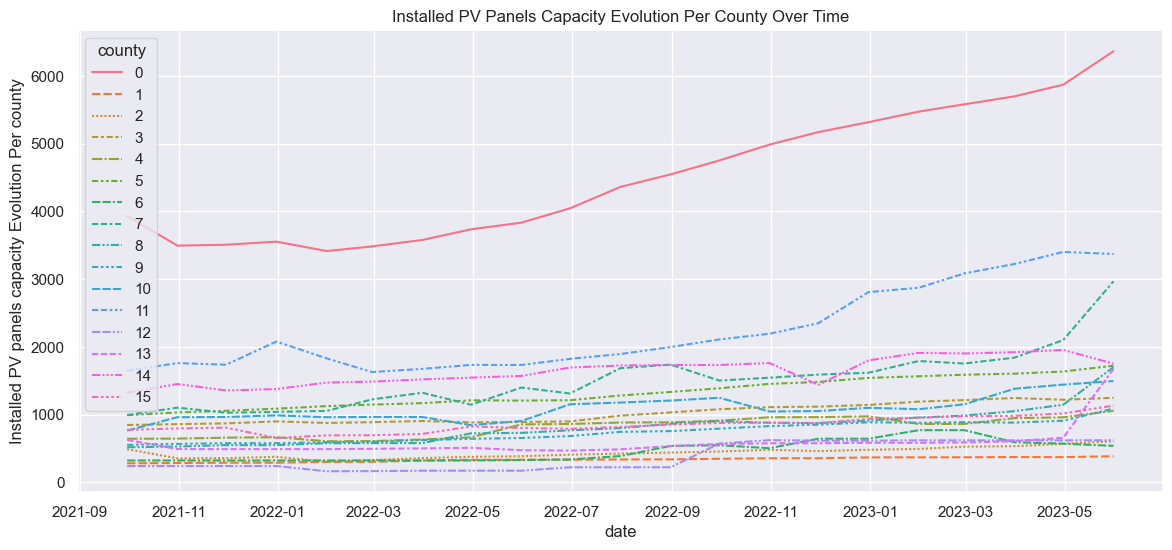

In [42]:
plt.figure(figsize=(14, 6))
sns.lineplot(client_data.groupby(['date','county'])['installed_capacity'].mean().unstack().resample('M').mean())
plt.ylabel("Installed PV panels capacity Evolution Per county")
plt.title("Installed PV Panels Capacity Evolution Per County Over Time")

The plots indicate that County 0 surpasses all other counties in terms of total installed PV capacity, reaching up to 6000. Additionally, Counties 7 and 11 have approximately 3000 PV capacity installed, while the remaining counties have capacities ranging between 200 and 2000.

It is noteworthy that the installed capacity is steadily increasing over time for Counties 0, 7, and 11.

<Axes: xlabel='county'>

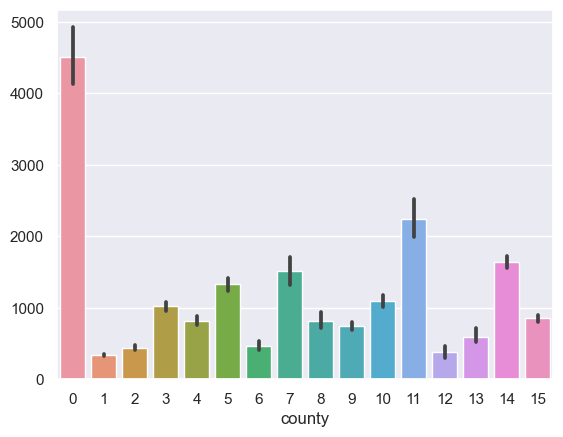

In [43]:
#bar chart to confirm 
sns.barplot(client_data.groupby(['date','county'])['installed_capacity'].mean().unstack().resample('M').mean())

<Axes: xlabel='date'>

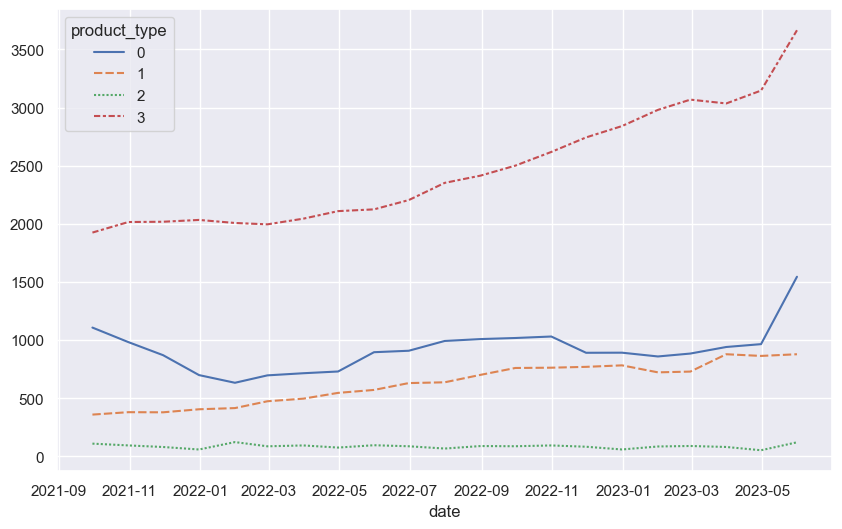

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(client_data.groupby(['date','product_type'])['installed_capacity'].mean().unstack().resample('M').mean())

In [45]:
client_data['date'] = client_data['date'].dt.date

In [46]:
client_data.columns

Index(['product_type', 'county', 'eic_count', 'installed_capacity',
       'is_business', 'date', 'data_block_id'],
      dtype='object')

In [47]:
grouped_data_2 = client_data.groupby(['date','county','product_type', 'is_business']).agg({
    'installed_capacity' : 'sum'
}).reset_index()

grouped_data_2


,date,county,product_type,is_business,installed_capacity
0,2021-09-01,0,0,1,400.00
1,2021-09-01,0,1,0,952.89
2,2021-09-01,0,1,1,1411.00
3,2021-09-01,0,2,0,166.40
4,2021-09-01,0,3,0,7207.88
...,...,...,...,...,...
41914,2023-05-29,15,0,1,620.00
41915,2023-05-29,15,1,0,415.60
41916,2023-05-29,15,1,1,624.50
41917,2023-05-29,15,3,0,2035.75


## Gas price data


In [48]:
gas_price = pd.read_csv('gas_prices.csv')

In [49]:
gas_price

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636


In [50]:
gas_price.duplicated().sum()

0

In [51]:
null(gas_price)

forecast_date            0.0
lowest_price_per_mwh     0.0
highest_price_per_mwh    0.0
origin_date              0.0
data_block_id            0.0
dtype: float64

In [52]:
gas_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [53]:
#changing datettime to datetime datatype
gas_price['forecast_date'] = pd.to_datetime(gas_price['forecast_date'])
gas_price['origin_date'] = pd.to_datetime(gas_price['origin_date'])

In [54]:
gas_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 25.0 KB


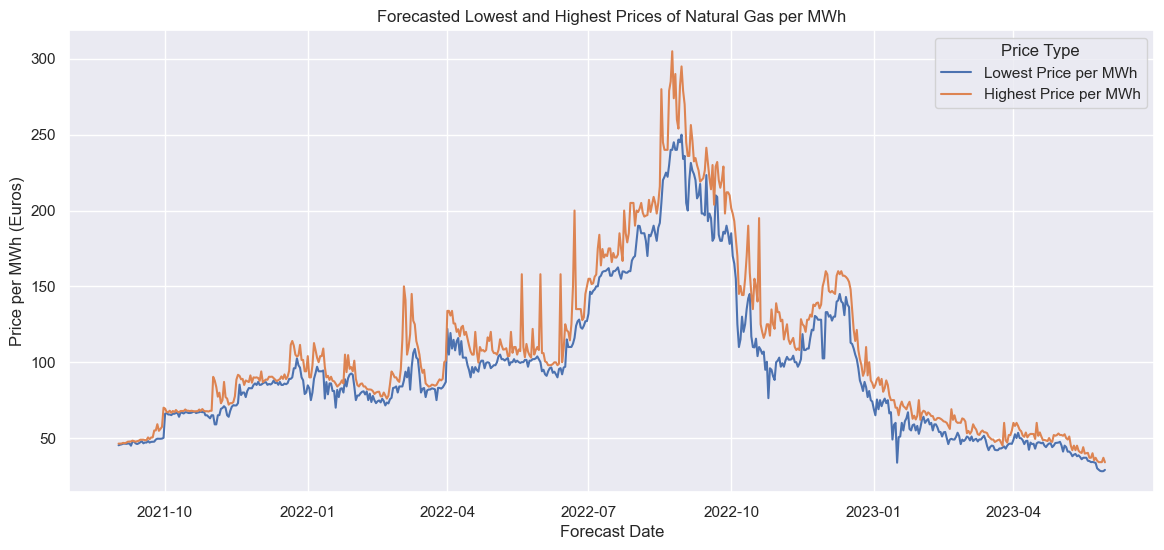

In [55]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='forecast_date', y='lowest_price_per_mwh', data=gas_price, label='Lowest Price per MWh')
sns.lineplot(x='forecast_date', y='highest_price_per_mwh', data=gas_price, label='Highest Price per MWh')

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Price per MWh (Euros)')
plt.title('Forecasted Lowest and Highest Prices of Natural Gas per MWh')
plt.legend(title='Price Type')

# Display the plot
plt.show()


In [56]:
gas_price['avg_price'] = gas_price["highest_price_per_mwh"] + gas_price["lowest_price_per_mwh"] / 2

## Electricity prices

In [57]:
electricity_price_data = pd.read_csv('electricity_prices.csv')

In [58]:
electricity_price_data

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


In [59]:
max_price = electricity_price_data['euros_per_mwh'].max()
print('Maximum Price for electricity is ', max_price)

Maximum Price for electricity is  4000.0


In [60]:
min_price = electricity_price_data['euros_per_mwh'].min()
print('Minimum Price for electricity is ', min_price)

Minimum Price for electricity is  -10.06


Since price cannot be negative we ae deleting the rows were price is <0.


In [61]:
price_less_than_zero = electricity_price_data.loc[electricity_price_data['euros_per_mwh']<0]
price_less_than_zero.shape

(29, 4)

In [62]:
filtered_data = electricity_price_data.loc[~(electricity_price_data['euros_per_mwh']<0)]
filtered_data

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15280,2023-05-30 18:00:00,82.10,2023-05-29 18:00:00,637
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637


In [63]:
electricity_price_data.shape

(15286, 4)

In [64]:
filtered_data.duplicated().sum()

0

In [65]:
filtered_data.to_csv('filtered_data_new.csv', index = False)


In [66]:
null(filtered_data)

forecast_date    0.0
euros_per_mwh    0.0
origin_date      0.0
data_block_id    0.0
dtype: float64

In [67]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15257 entries, 0 to 15284
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15257 non-null  object 
 1   euros_per_mwh  15257 non-null  float64
 2   origin_date    15257 non-null  object 
 3   data_block_id  15257 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 596.0+ KB


In [68]:
filtered_data.describe()

,euros_per_mwh,data_block_id
count,15257.000000,15257.000000
mean,157.367292,318.418955
std,121.063766,183.589286
min,0.000000,1.000000
25%,85.400000,159.000000
50%,128.530000,318.000000
75%,199.840000,477.000000
max,4000.000000,637.000000


In [69]:
##changing datettime to datetime datatype
filtered_data['forecast_date'] = pd.to_datetime(filtered_data['forecast_date'])
filtered_data['origin_date'] = pd.to_datetime(filtered_data['origin_date'])


C:\Users\91828\AppData\Local\Temp\ipykernel_31204\3475209991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['forecast_date'] = pd.to_datetime(filtered_data['forecast_date'])
C:\Users\91828\AppData\Local\Temp\ipykernel_31204\3475209991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['origin_date'] = pd.to_datetime(filtered_data['origin_date'])


In [70]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15257 entries, 0 to 15284
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15257 non-null  datetime64[ns]
 1   euros_per_mwh  15257 non-null  float64       
 2   origin_date    15257 non-null  datetime64[ns]
 3   data_block_id  15257 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 596.0 KB


<Axes: xlabel='forecast_date', ylabel='euros_per_mwh'>

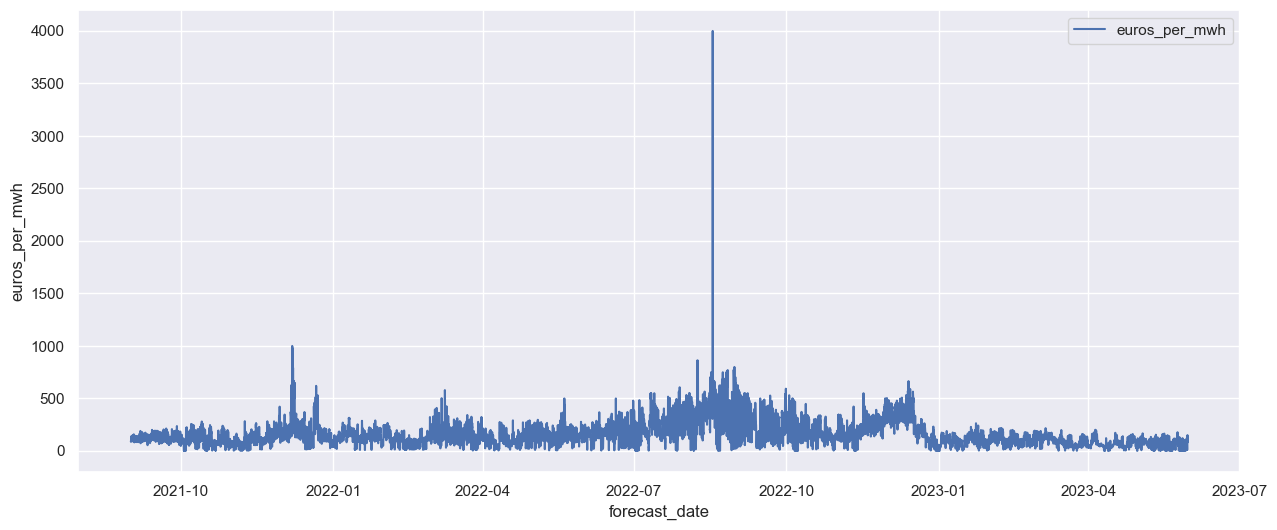

In [71]:
plt.figure(figsize=(15, 6))

sns.lineplot(x='forecast_date', y='euros_per_mwh', data=filtered_data, label='euros_per_mwh')

In [72]:
filtered_data.euros_per_mwh.max()

4000.0

In [73]:
filtered_data.loc[filtered_data['euros_per_mwh']==4000.0]

,forecast_date,euros_per_mwh,origin_date,data_block_id
8416,2022-08-17 17:00:00,4000.0,2022-08-16 17:00:00,351


C:\Users\91828\AppData\Local\Temp\ipykernel_31204\456578984.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(filtered_data['euros_per_mwh'])


<Axes: xlabel='euros_per_mwh', ylabel='Density'>

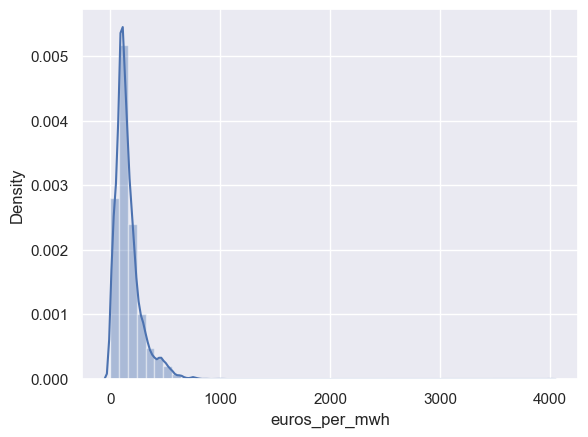

In [74]:
sns.distplot(filtered_data['euros_per_mwh'])

<Axes: >

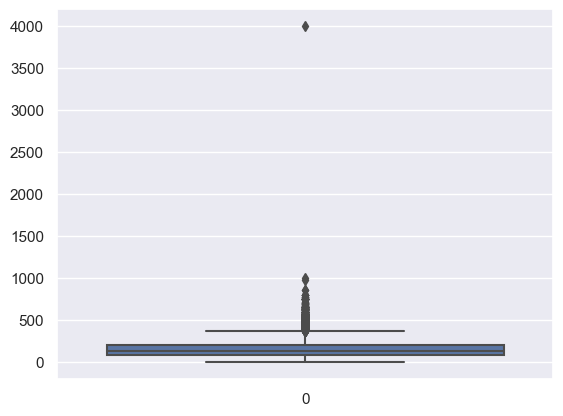

In [75]:
sns.boxplot(filtered_data['euros_per_mwh'])

In [76]:
#capping - winsorization
upper_limit = filtered_data['euros_per_mwh'].quantile(0.99)
upper_limit

562.5604000000003

In [77]:
filtered_data['euros_per_mwh'] = np.where(filtered_data['euros_per_mwh']>=upper_limit,upper_limit,filtered_data['euros_per_mwh'])

C:\Users\91828\AppData\Local\Temp\ipykernel_31204\291251685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['euros_per_mwh'] = np.where(filtered_data['euros_per_mwh']>=upper_limit,upper_limit,filtered_data['euros_per_mwh'])


In [78]:
filtered_data.describe()

,euros_per_mwh,data_block_id
count,15257.000000,15257.000000
mean,156.263159,318.418955
std,113.318614,183.589286
min,0.000000,1.000000
25%,85.400000,159.000000
50%,128.530000,318.000000
75%,199.840000,477.000000
max,562.560400,637.000000


In [79]:
# sns.boxplot(filtered_data['euros_per_mwh'])

<Axes: xlabel='forecast_date', ylabel='euros_per_mwh'>

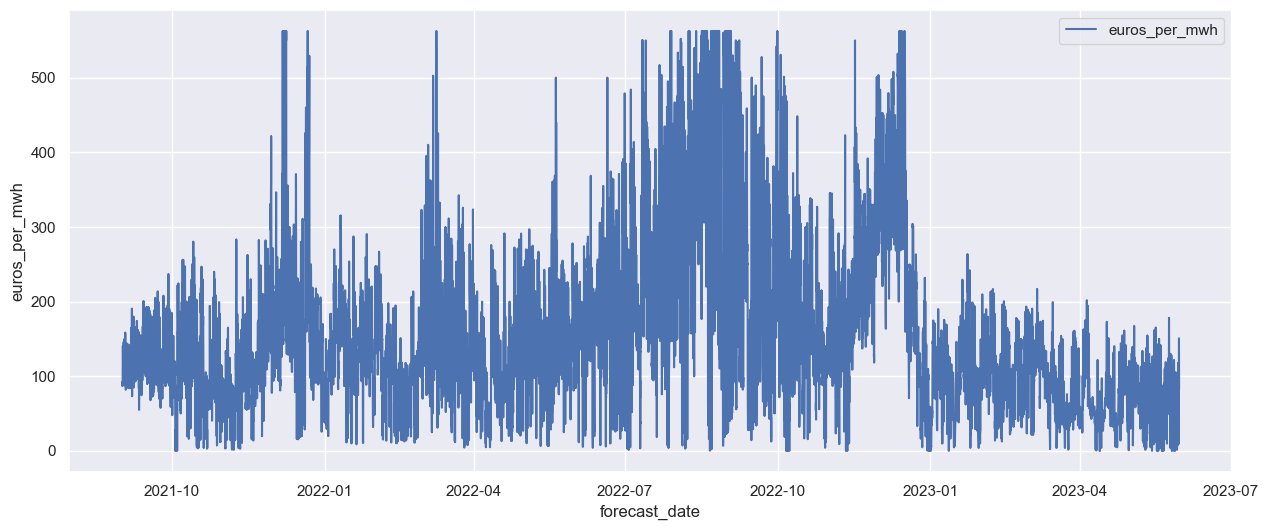

In [80]:
plt.figure(figsize=(15, 6))

sns.lineplot(x='forecast_date', y='euros_per_mwh', data=filtered_data, label='euros_per_mwh')

<Axes: xlabel='forecast_date', ylabel='euros_per_mwh'>

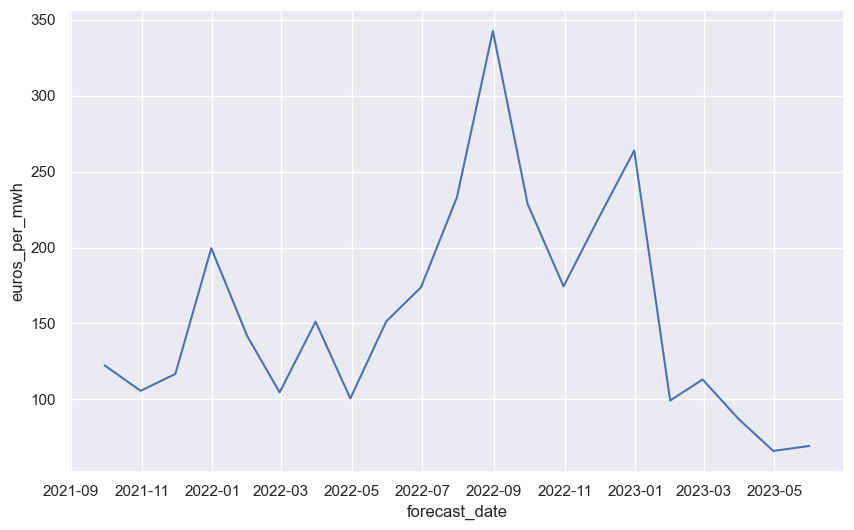

In [81]:
plt.figure(figsize=(10, 6))
# sns.lineplot(electricity_price_data.groupby(['forecast_date'])['euros_per_mwh'].mean().unstack().resample('M').mean())
sns.lineplot(filtered_data.groupby(['forecast_date'])['euros_per_mwh'].mean().resample('M').mean())

<Axes: xlabel='forecast_date', ylabel='euros_per_mwh'>

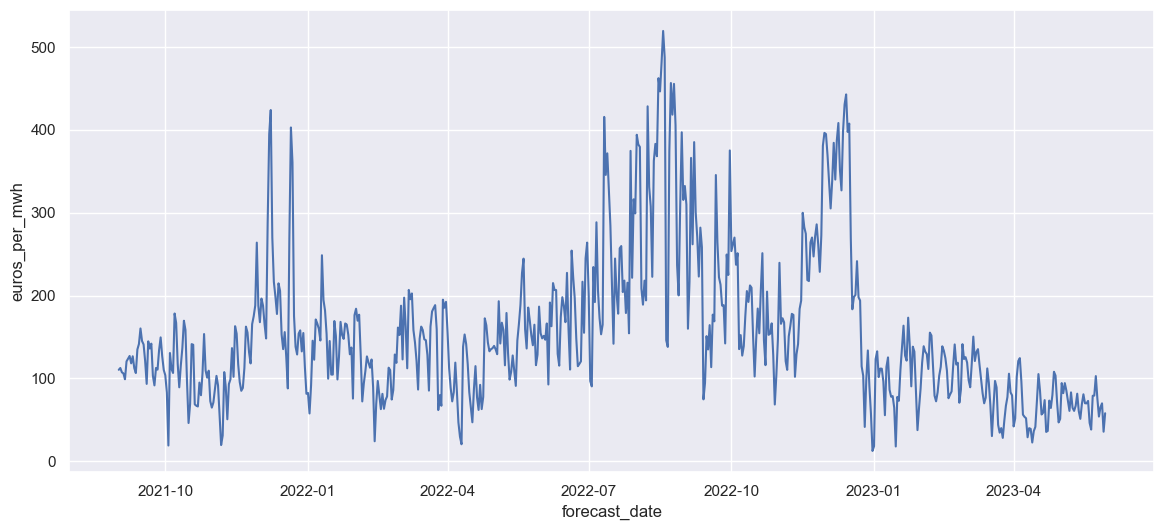

In [82]:
plt.figure(figsize=(14, 6))
sns.lineplot(filtered_data.groupby(['forecast_date'])['euros_per_mwh'].mean().resample('D').mean())

In [83]:
filtered_data['forecast_date'] = filtered_data['forecast_date'].dt.date

C:\Users\91828\AppData\Local\Temp\ipykernel_31204\255858567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['forecast_date'] = filtered_data['forecast_date'].dt.date


In [84]:
grouped_data_3 = filtered_data.groupby('forecast_date')['euros_per_mwh'].median().reset_index()
grouped_data_3

,forecast_date,euros_per_mwh
0,2021-09-01,106.815
1,2021-09-02,106.445
2,2021-09-03,98.730
3,2021-09-04,99.040
4,2021-09-05,91.210
...,...,...
632,2023-05-26,61.160
633,2023-05-27,82.700
634,2023-05-28,75.315
635,2023-05-29,21.150


The electricity price tends to fluctuate around the range of 100-120 EUR/MWh. However, notable spikes are observed in the months of November and December, as well as in August and September.

## Historical weather data

In [85]:
weather_data = pd.read_csv('historical_weather.csv')

In [86]:
weather_data.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [87]:
weather_data.shape

(1710802, 18)

In [88]:
weather_data.duplicated().sum()

0

In [89]:
null(weather_data)

datetime                  0.0
temperature               0.0
dewpoint                  0.0
rain                      0.0
snowfall                  0.0
surface_pressure          0.0
cloudcover_total          0.0
cloudcover_low            0.0
cloudcover_mid            0.0
cloudcover_high           0.0
windspeed_10m             0.0
winddirection_10m         0.0
shortwave_radiation       0.0
direct_solar_radiation    0.0
diffuse_radiation         0.0
latitude                  0.0
longitude                 0.0
data_block_id             0.0
dtype: float64

In [90]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [91]:
forecast_data = pd.read_csv('forecast_weather.csv')

In [92]:
forecast_data.shape

(3424512, 18)

In [93]:
forecast_data.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [94]:
df_locations  = pd.read_csv("weather_station_to_county_mapping.csv")


In [95]:
df_locations

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [96]:
df_locations.county.unique()

array([nan, 10.,  1.,  7.,  6.,  9.,  0., 14.,  3., 13., 11.,  4.,  5.,
       15.,  8.,  2.])

In [97]:
forecast_data = forecast_data.merge(df_locations , how ='left' , on =['latitude' , 'longitude'] )

In [98]:
forecast_data.drop(columns = 'county_name', axis = 1, inplace = True)

In [99]:
forecast_data.isna().sum()

latitude                                   0
longitude                                  0
origin_datetime                            0
hours_ahead                                0
temperature                                0
dewpoint                                   0
cloudcover_high                            0
cloudcover_low                             0
cloudcover_mid                             0
cloudcover_total                           0
10_metre_u_wind_component                  0
10_metre_v_wind_component                  0
data_block_id                              0
forecast_datetime                          0
direct_solar_radiation                     0
surface_solar_radiation_downwards          2
snowfall                                   0
total_precipitation                        0
county                               3027024
dtype: int64

In [100]:
forecast_data.dropna(axis = 0 , inplace = True)

In [101]:
forecast_data['county'] = forecast_data.county.astype('int64')


In [102]:
forecast_data.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
10,57.6,26.7,2021-09-01 02:00:00,1,9.876489,9.120386,0.000000,0.025940,0.003006,0.026001,1.048755,-2.526303,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15
11,57.6,27.2,2021-09-01 02:00:00,1,10.815576,10.046899,0.747406,0.083191,0.000000,0.761780,1.183276,-3.873715,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15
23,57.9,26.2,2021-09-01 02:00:00,1,10.058984,9.031396,0.248322,0.104279,0.066223,0.332809,1.523974,-2.439878,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,13
24,57.9,26.7,2021-09-01 02:00:00,1,9.762109,8.523584,0.002258,0.101929,0.032730,0.105255,1.262256,-2.455014,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15
25,57.9,27.2,2021-09-01 02:00:00,1,10.050806,9.018335,0.057373,0.080933,0.004593,0.133881,1.588183,-2.117612,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15


In [103]:
forecast_data.columns

Index(['latitude', 'longitude', 'origin_datetime', 'hours_ahead',
       'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'data_block_id', 'forecast_datetime',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'county'],
      dtype='object')

In [104]:
forecast_data.drop(columns =['origin_datetime' , 'latitude', 'longitude' , 'hours_ahead' ] , inplace = True)
forecast_data.rename(columns = {'forecast_datetime' : 'datetime'} ,inplace = True)

In [105]:
forecast_data['datetime'] = pd.to_datetime(forecast_data['datetime'] , utc = True)


In [106]:
cols  = forecast_data.columns.difference(['county' , 'datetime' , 'data_block_id'])
forecast_data = forecast_data.groupby(['county' , 'datetime' , 'data_block_id'])[cols].mean().reset_index()

In [107]:
forecast_data.shape

(214004, 15)

In [108]:
data  = data.merge(forecast_data , on  = ['data_block_id' , 'county' , 'datetime'] , how = 'left')
data.dropna(inplace = True)

In [109]:
gas_price.drop(columns = ['origin_date'] , inplace = True)

In [110]:
data = data.merge(gas_price , on =['data_block_id'] , how ='left')


In [111]:
data.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,...,dewpoint,direct_solar_radiation,snowfall,surface_solar_radiation_downwards,temperature,total_precipitation,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,avg_price
0,7,0,1,0.000,0,2021-09-02 00:00:00+00:00,1,2978,25,2021,...,4.961145,0.0,0.0,0.0,10.069604,0.0,2021-09-01,45.23,46.32,68.935
1,7,0,1,20.186,1,2021-09-02 00:00:00+00:00,1,2979,25,2021,...,4.961145,0.0,0.0,0.0,10.069604,0.0,2021-09-01,45.23,46.32,68.935
2,7,0,2,0.000,0,2021-09-02 00:00:00+00:00,1,2980,26,2021,...,4.961145,0.0,0.0,0.0,10.069604,0.0,2021-09-01,45.23,46.32,68.935
3,7,0,2,3.609,1,2021-09-02 00:00:00+00:00,1,2981,26,2021,...,4.961145,0.0,0.0,0.0,10.069604,0.0,2021-09-01,45.23,46.32,68.935
4,7,0,3,0.056,0,2021-09-02 00:00:00+00:00,1,2982,27,2021,...,4.961145,0.0,0.0,0.0,10.069604,0.0,2021-09-01,45.23,46.32,68.935


In [112]:
data['hour'] =  data.datetime.dt.hour
data['day'] = data.datetime.dt.day
data['month'] = data.datetime.dt.month
data['day_of_week'] = data.datetime.dt.dayofweek
data['day_of_year'] = data.datetime.dt.dayofyear

In [113]:
electricity_price_data.forecast_date = pd.to_datetime(electricity_price_data.forecast_date ,  utc = True )
electricity_price_data.rename(columns = {'forecast_date' : 'datetime'} , inplace = True)

In [114]:
electricity_price_data['datetime'] = pd.to_datetime(electricity_price_data['datetime'] , utc = True)
electricity_price_data['hour'] = electricity_price_data.datetime.dt.hour
electricity_price_data.head()

,datetime,euros_per_mwh,origin_date,data_block_id,hour
0,2021-09-01 00:00:00+00:00,92.51,2021-08-31 00:00:00,1,0
1,2021-09-01 01:00:00+00:00,88.90,2021-08-31 01:00:00,1,1
2,2021-09-01 02:00:00+00:00,87.35,2021-08-31 02:00:00,1,2
3,2021-09-01 03:00:00+00:00,86.88,2021-08-31 03:00:00,1,3
4,2021-09-01 04:00:00+00:00,88.43,2021-08-31 04:00:00,1,4


In [115]:
data = data.merge(electricity_price_data[['euros_per_mwh' , 'data_block_id' , 'hour']] , how ='left' , on =['hour' , 'data_block_id'])
data.dropna(inplace = True)

In [116]:
client_data.rename(columns = {"date" : "datetime"} , inplace = True)

In [117]:
client_data['datetime'] = pd.to_datetime(client_data.datetime , utc = True)

In [118]:
client_data.columns


Index(['product_type', 'county', 'eic_count', 'installed_capacity',
       'is_business', 'datetime', 'data_block_id'],
      dtype='object')

In [119]:
data  = data.merge(client_data , how ='left' , on = ['county' , 'is_business' , 'product_type' , 'data_block_id' , 'is_business'])

In [120]:
data

,county,is_business,product_type,target,is_consumption,datetime_x,data_block_id,row_id,prediction_unit_id,year,...,avg_price,hour,day,month,day_of_week,day_of_year,euros_per_mwh,eic_count,installed_capacity,datetime_y
0,7,0,1,0.000,0,2021-09-02 00:00:00+00:00,1,2978,25,2021,...,68.935,0,2,9,3,245,92.51,NaN,NaN,NaT
1,7,0,1,20.186,1,2021-09-02 00:00:00+00:00,1,2979,25,2021,...,68.935,0,2,9,3,245,92.51,NaN,NaN,NaT
2,7,0,2,0.000,0,2021-09-02 00:00:00+00:00,1,2980,26,2021,...,68.935,0,2,9,3,245,92.51,NaN,NaN,NaT
3,7,0,2,3.609,1,2021-09-02 00:00:00+00:00,1,2981,26,2021,...,68.935,0,2,9,3,245,92.51,NaN,NaN,NaT
4,7,0,3,0.056,0,2021-09-02 00:00:00+00:00,1,2982,27,2021,...,68.935,0,2,9,3,245,92.51,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991331,15,1,0,197.233,1,2023-05-31 23:00:00+00:00,637,2018347,64,2023,...,48.500,23,31,5,2,151,-1.29,15.0,620.0,2023-05-29 00:00:00+00:00
991332,15,1,1,0.000,0,2023-05-31 23:00:00+00:00,637,2018348,59,2023,...,48.500,23,31,5,2,151,-1.29,20.0,624.5,2023-05-29 00:00:00+00:00
991333,15,1,1,28.404,1,2023-05-31 23:00:00+00:00,637,2018349,59,2023,...,48.500,23,31,5,2,151,-1.29,20.0,624.5,2023-05-29 00:00:00+00:00
991334,15,1,3,0.000,0,2023-05-31 23:00:00+00:00,637,2018350,60,2023,...,48.500,23,31,5,2,151,-1.29,55.0,2188.2,2023-05-29 00:00:00+00:00


In [122]:
data.rename(columns= {'datetime_x' : 'datetime'} , inplace = True)
data.drop(columns = 'datetime_y' , inplace = True )

In [123]:
data.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'year',
       'date', '10_metre_u_wind_component', '10_metre_v_wind_component',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', 'dewpoint', 'direct_solar_radiation', 'snowfall',
       'surface_solar_radiation_downwards', 'temperature',
       'total_precipitation', 'forecast_date', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'avg_price', 'hour', 'day', 'month',
       'day_of_week', 'day_of_year', 'euros_per_mwh', 'eic_count',
       'installed_capacity'],
      dtype='object')

In [124]:
data.dropna(inplace = True)


In [125]:
print(data.shape)
print(data.info())

(987546, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 987546 entries, 1488 to 991335
Data columns (total 35 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   county                             987546 non-null  int64              
 1   is_business                        987546 non-null  int64              
 2   product_type                       987546 non-null  int64              
 3   target                             987546 non-null  float64            
 4   is_consumption                     987546 non-null  int64              
 5   datetime                           987546 non-null  datetime64[ns, UTC]
 6   data_block_id                      987546 non-null  int64              
 7   row_id                             987546 non-null  int64              
 8   prediction_unit_id                 987546 non-null  int64              
 9   year                 

In [126]:
data.drop(columns = [ 'row_id' ,'data_block_id'] , inplace = True)

In [127]:
data

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,year,date,10_metre_u_wind_component,...,highest_price_per_mwh,avg_price,hour,day,month,day_of_week,day_of_year,euros_per_mwh,eic_count,installed_capacity
1488,7,0,1,0.000,0,2021-09-03 00:00:00+00:00,25,2021,2021-09-03,6.375530,...,46.29,69.1,0,3,9,4,246,96.99,31.0,334.80
1489,7,0,1,18.267,1,2021-09-03 00:00:00+00:00,25,2021,2021-09-03,6.375530,...,46.29,69.1,0,3,9,4,246,96.99,31.0,334.80
1490,7,0,2,0.000,0,2021-09-03 00:00:00+00:00,26,2021,2021-09-03,6.375530,...,46.29,69.1,0,3,9,4,246,96.99,5.0,50.50
1491,7,0,2,2.714,1,2021-09-03 00:00:00+00:00,26,2021,2021-09-03,6.375530,...,46.29,69.1,0,3,9,4,246,96.99,5.0,50.50
1492,7,0,3,0.030,0,2021-09-03 00:00:00+00:00,27,2021,2021-09-03,6.375530,...,46.29,69.1,0,3,9,4,246,96.99,147.0,1832.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991331,15,1,0,197.233,1,2023-05-31 23:00:00+00:00,64,2023,2023-05-31,3.560166,...,34.00,48.5,23,31,5,2,151,-1.29,15.0,620.00
991332,15,1,1,0.000,0,2023-05-31 23:00:00+00:00,59,2023,2023-05-31,3.560166,...,34.00,48.5,23,31,5,2,151,-1.29,20.0,624.50
991333,15,1,1,28.404,1,2023-05-31 23:00:00+00:00,59,2023,2023-05-31,3.560166,...,34.00,48.5,23,31,5,2,151,-1.29,20.0,624.50
991334,15,1,3,0.000,0,2023-05-31 23:00:00+00:00,60,2023,2023-05-31,3.560166,...,34.00,48.5,23,31,5,2,151,-1.29,55.0,2188.20


In [ ]:
# x = 

In [185]:


# Assuming 'merged_data' is already defined
X_sample = data.drop(columns=['target'])

# Select only numeric columns
X_sample = X_sample.select_dtypes(include=[np.number])

y_sample = data['target']

selector = SelectKBest(score_func=mutual_info_regression, k=15)
selector.fit(X_sample, y_sample)

selected_indices = selector.get_support(indices=True)
selected_features = X_sample.columns[selected_indices]
print("Selected features:")
print(selected_features)



Selected features:
Index(['datetime', 'prediction_unit_id', 'dewpoint', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'temperature',
       'highest_price_per_mwh', 'avg_price', 'hour', 'euros_per_mwh',
       'eic_count', 'installed_capacity', 'product_type_3', 'is_consumption_0',
       'is_consumption_1'],
      dtype='object')


In [186]:
feature_scores = selector.scores_[selected_indices]
# Create a DataFrame for the selected features and their scores
feature_scores_df = pd.DataFrame({'Feature': selected_features, 'Score': feature_scores})

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

In [187]:
feature_scores_df

,Feature,Score
11,installed_capacity,0.776819
1,prediction_unit_id,0.467474
10,eic_count,0.394623
14,is_consumption_1,0.264069
13,is_consumption_0,0.263161
0,datetime,0.248723
4,surface_solar_radiation_downwards,0.171407
3,direct_solar_radiation,0.143533
9,euros_per_mwh,0.116490
8,hour,0.086749


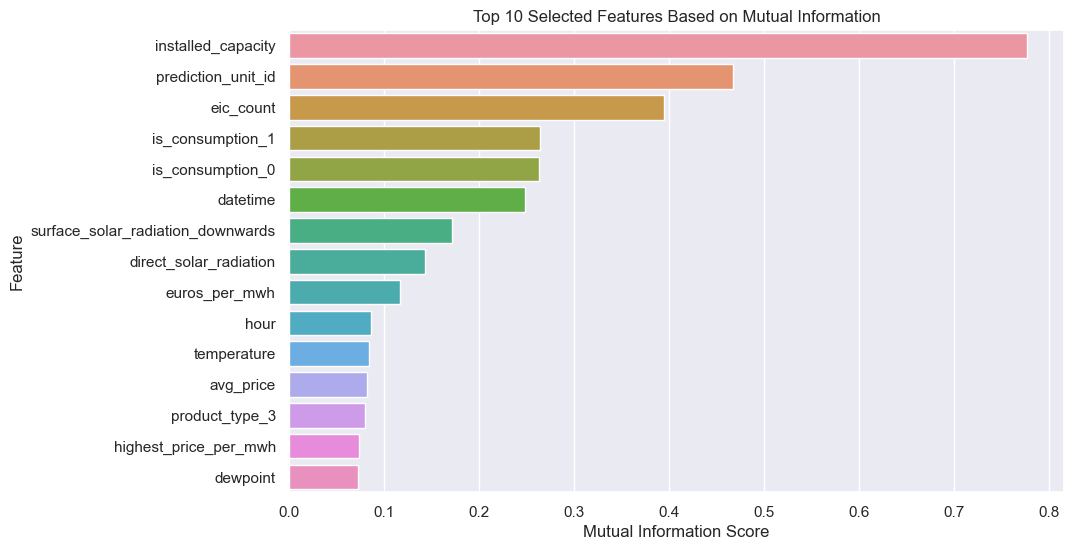

In [188]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores_df)
plt.title('Top 10 Selected Features Based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
pip install statsmodels

In [ ]:
# final_data = data[['installed_capacity','eic_count','is_consumption','surface_solar_radiation_downwards',
#                   'product_type','direct_solar_radiation','euros_per_mwh','county',
#                   'hour','temperature','avg_price','highest_price_per_mwh','dewpoint','lowest_price_per_mwh','target','is_business','product_type']]

In [128]:
cat_vars = ['county' , 'is_business' , 'product_type' ,'is_consumption']
cat_vars  = pd.get_dummies(data[cat_vars] ,  columns = cat_vars , drop_first = False  , dtype= int)

In [129]:
data.drop(columns = ['county' , 'is_business' , 'product_type' ,'is_consumption', 'forecast_date'] , inplace = True)

In [130]:
data  = pd.concat([data , cat_vars] , axis = 1).copy()


In [131]:
data

,target,datetime,prediction_unit_id,year,date,10_metre_u_wind_component,10_metre_v_wind_component,cloudcover_high,cloudcover_low,cloudcover_mid,...,county_14,county_15,is_business_0,is_business_1,product_type_0,product_type_1,product_type_2,product_type_3,is_consumption_0,is_consumption_1
1488,0.000,2021-09-03 00:00:00+00:00,25,2021,2021-09-03,6.375530,-1.703013,0.000000,0.104446,0.719030,...,0,0,1,0,0,1,0,0,1,0
1489,18.267,2021-09-03 00:00:00+00:00,25,2021,2021-09-03,6.375530,-1.703013,0.000000,0.104446,0.719030,...,0,0,1,0,0,1,0,0,0,1
1490,0.000,2021-09-03 00:00:00+00:00,26,2021,2021-09-03,6.375530,-1.703013,0.000000,0.104446,0.719030,...,0,0,1,0,0,0,1,0,1,0
1491,2.714,2021-09-03 00:00:00+00:00,26,2021,2021-09-03,6.375530,-1.703013,0.000000,0.104446,0.719030,...,0,0,1,0,0,0,1,0,0,1
1492,0.030,2021-09-03 00:00:00+00:00,27,2021,2021-09-03,6.375530,-1.703013,0.000000,0.104446,0.719030,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991331,197.233,2023-05-31 23:00:00+00:00,64,2023,2023-05-31,3.560166,-0.286433,0.453412,0.045816,0.017661,...,0,1,0,1,1,0,0,0,0,1
991332,0.000,2023-05-31 23:00:00+00:00,59,2023,2023-05-31,3.560166,-0.286433,0.453412,0.045816,0.017661,...,0,1,0,1,0,1,0,0,1,0
991333,28.404,2023-05-31 23:00:00+00:00,59,2023,2023-05-31,3.560166,-0.286433,0.453412,0.045816,0.017661,...,0,1,0,1,0,1,0,0,0,1
991334,0.000,2023-05-31 23:00:00+00:00,60,2023,2023-05-31,3.560166,-0.286433,0.453412,0.045816,0.017661,...,0,1,0,1,0,0,0,1,1,0


In [132]:
data.drop(columns = 'date', inplace = True)

In [133]:
cols  = data.columns.difference(['target'])


In [134]:
cols

Index(['10_metre_u_wind_component', '10_metre_v_wind_component', 'avg_price',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', 'county_10', 'county_11', 'county_13', 'county_14',
       'county_15', 'county_7', 'county_8', 'datetime', 'day', 'day_of_week',
       'day_of_year', 'dewpoint', 'direct_solar_radiation', 'eic_count',
       'euros_per_mwh', 'highest_price_per_mwh', 'hour', 'installed_capacity',
       'is_business_0', 'is_business_1', 'is_consumption_0',
       'is_consumption_1', 'lowest_price_per_mwh', 'month',
       'prediction_unit_id', 'product_type_0', 'product_type_1',
       'product_type_2', 'product_type_3', 'snowfall',
       'surface_solar_radiation_downwards', 'temperature',
       'total_precipitation', 'year'],
      dtype='object')

In [ ]:
# X = data.drop(columns = 'target')

In [135]:
data['datetime'] = data['datetime'].astype('int64') // 10**9


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987546 entries, 1488 to 991335
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   target                             987546 non-null  float64
 1   datetime                           987546 non-null  int64  
 2   prediction_unit_id                 987546 non-null  int64  
 3   year                               987546 non-null  int64  
 4   10_metre_u_wind_component          987546 non-null  float64
 5   10_metre_v_wind_component          987546 non-null  float64
 6   cloudcover_high                    987546 non-null  float64
 7   cloudcover_low                     987546 non-null  float64
 8   cloudcover_mid                     987546 non-null  float64
 9   cloudcover_total                   987546 non-null  float64
 10  dewpoint                           987546 non-null  float64
 11  direct_solar_radiation             9

In [137]:


x_train , x_test , y_train , y_test = train_test_split(data[cols] ,data['target'] , random_state = 42 , test_size = 0.20)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(790036, 41)
(197510, 41)
(790036,)
(197510,)


In [138]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [139]:
pip install optuna


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [140]:


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['target'], test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 19000, 21000),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'num_leaves': trial.suggest_int('num_leaves', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 15, 25),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9)
    }
    
    lgb_reg = lgb.LGBMRegressor(**param, device='gpu')
    
    # Split the training data further for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Define the callbacks
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
    
    # Train the model with the specified parameters
    lgb_reg.fit(X_train_split, y_train_split, 
                eval_set=[(X_val_split, y_val_split)], 
                callbacks=callbacks)
    
    # Predict on the validation set
    y_pred = lgb_reg.predict(X_val_split)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_val_split, y_pred)
    
    return mse

# Create an Optuna study to minimize the objective function
study = optuna.create_study(direction='minimize')

# Optimize the study over 10 trials
study.optimize(objective, n_trials=10)

# Retrieve and print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)







[I 2024-08-07 11:48:40,973] A new study created in memory with name: no-name-afbc7f18-a3e4-4c5a-a74b-69949d860dad


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.032400 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 7455.52
[200]	valid_0's l2: 6060.05
[300]	valid_0's l2: 5463.98
[400]	valid_0's l2: 5020.69
[500]	valid_0's l2: 4734.76
[600]	valid_0's l2: 4511.44
[700]	valid_0's l2: 4299.57
[800]	valid_0's l2: 4151.23
[900]	valid_0's l2: 4042.62
[1000]	valid_0's l2: 3972.66
[1100]	valid_0's l2: 3899.71
[1200]	valid_0's l2: 3825.46
[1300]	valid_0's l2: 3776.55
[1400]	valid_0's l2: 3718.9
[1500]	valid_0's l2: 3671.3

[I 2024-08-07 12:08:36,157] Trial 0 finished with value: 2971.302428365186 and parameters: {'n_estimators': 19554, 'learning_rate': 0.13608005649014035, 'num_leaves': 68, 'max_depth': 19, 'subsample': 0.7862552979774933}. Best is trial 0 with value: 2971.302428365186.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.027024 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 8066.97
[200]	valid_0's l2: 6482.58
[300]	valid_0's l2: 5717.75
[400]	valid_0's l2: 5261.45
[500]	valid_0's l2: 5014.55
[600]	valid_0's l2: 4763.79
[700]	valid_0's l2: 4580.28
[800]	valid_0's l2: 4436.07
[900]	valid_0's l2: 4310.94
[1000]	valid_0's l2: 4211.4
[1100]	valid_0's l2: 4130.2
[1200]	valid_0's l2: 4064.06
[1300]	valid_0's l2: 4014.96
[1400]	valid_0's l2: 3955.99
[1500]	valid_0's l2: 3911.42

[I 2024-08-07 12:25:31,110] Trial 1 finished with value: 3091.3789956488263 and parameters: {'n_estimators': 19380, 'learning_rate': 0.1483374695366058, 'num_leaves': 55, 'max_depth': 17, 'subsample': 0.7189845312591974}. Best is trial 0 with value: 2971.302428365186.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.024186 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 7124.31
[200]	valid_0's l2: 5869.48
[300]	valid_0's l2: 5218.56
[400]	valid_0's l2: 4834.14
[500]	valid_0's l2: 4544.65
[600]	valid_0's l2: 4360.43
[700]	valid_0's l2: 4195.04
[800]	valid_0's l2: 4042.67
[900]	valid_0's l2: 3949.89
[1000]	valid_0's l2: 3861.62
[1100]	valid_0's l2: 3779.18
[1200]	valid_0's l2: 3726.31
[1300]	valid_0's l2: 3663.35
[1400]	valid_0's l2: 3607.6
[1500]	valid_0's l2: 3562.4

[I 2024-08-07 12:58:35,158] Trial 2 finished with value: 2905.039832615079 and parameters: {'n_estimators': 20467, 'learning_rate': 0.10938111817299637, 'num_leaves': 89, 'max_depth': 15, 'subsample': 0.8363228453070195}. Best is trial 2 with value: 2905.039832615079.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.025393 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 8087.42
[200]	valid_0's l2: 6502.19
[300]	valid_0's l2: 5761.43
[400]	valid_0's l2: 5320.14
[500]	valid_0's l2: 4998.67
[600]	valid_0's l2: 4755.45
[700]	valid_0's l2: 4535.21
[800]	valid_0's l2: 4405.36
[900]	valid_0's l2: 4276
[1000]	valid_0's l2: 4196.56
[1100]	valid_0's l2: 4111.41
[1200]	valid_0's l2: 4042.57
[1300]	valid_0's l2: 3989.02
[1400]	valid_0's l2: 3930.75
[1500]	valid_0's l2: 3874.11


[I 2024-08-07 13:22:08,581] Trial 3 finished with value: 3048.341371123668 and parameters: {'n_estimators': 19071, 'learning_rate': 0.14696521833473564, 'num_leaves': 55, 'max_depth': 19, 'subsample': 0.8039289785993614}. Best is trial 2 with value: 2905.039832615079.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.027473 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 8054.76
[200]	valid_0's l2: 6640.27
[300]	valid_0's l2: 5881.81
[400]	valid_0's l2: 5419.05
[500]	valid_0's l2: 5074.98
[600]	valid_0's l2: 4812.17
[700]	valid_0's l2: 4626.3
[800]	valid_0's l2: 4447.41
[900]	valid_0's l2: 4324.82
[1000]	valid_0's l2: 4232.89
[1100]	valid_0's l2: 4143.18
[1200]	valid_0's l2: 4066.97
[1300]	valid_0's l2: 3990.55
[1400]	valid_0's l2: 3908.66
[1500]	valid_0's l2: 3849.6

[I 2024-08-07 13:50:35,308] Trial 4 finished with value: 2886.850527673341 and parameters: {'n_estimators': 19337, 'learning_rate': 0.07972332158676076, 'num_leaves': 77, 'max_depth': 22, 'subsample': 0.8010925204759234}. Best is trial 4 with value: 2886.850527673341.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.029001 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 8447.41
[200]	valid_0's l2: 6869.58
[300]	valid_0's l2: 6078.18
[400]	valid_0's l2: 5527.51
[500]	valid_0's l2: 5150.16
[600]	valid_0's l2: 4886.24
[700]	valid_0's l2: 4689.91
[800]	valid_0's l2: 4526.81
[900]	valid_0's l2: 4404.33
[1000]	valid_0's l2: 4297.61
[1100]	valid_0's l2: 4209.82
[1200]	valid_0's l2: 4113.72
[1300]	valid_0's l2: 4045.02
[1400]	valid_0's l2: 3989.57
[1500]	valid_0's l2: 3928.

[I 2024-08-07 14:15:29,901] Trial 5 finished with value: 3039.5096168607265 and parameters: {'n_estimators': 20968, 'learning_rate': 0.1345813281902609, 'num_leaves': 51, 'max_depth': 21, 'subsample': 0.7712336240949479}. Best is trial 4 with value: 2886.850527673341.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.023727 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 7732.79
[200]	valid_0's l2: 6366.9
[300]	valid_0's l2: 5672.15
[400]	valid_0's l2: 5225.14
[500]	valid_0's l2: 4927.76
[600]	valid_0's l2: 4665.09
[700]	valid_0's l2: 4477.13
[800]	valid_0's l2: 4345.45
[900]	valid_0's l2: 4231.33
[1000]	valid_0's l2: 4119.01
[1100]	valid_0's l2: 4029.12
[1200]	valid_0's l2: 3945.1
[1300]	valid_0's l2: 3881.59
[1400]	valid_0's l2: 3831.18
[1500]	valid_0's l2: 3786.11

[I 2024-08-07 14:58:05,777] Trial 6 finished with value: 2961.7918408930395 and parameters: {'n_estimators': 20918, 'learning_rate': 0.10522844442800128, 'num_leaves': 74, 'max_depth': 23, 'subsample': 0.7245234583991838}. Best is trial 4 with value: 2886.850527673341.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.025761 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 9050.22
[200]	valid_0's l2: 7399.13
[300]	valid_0's l2: 6548.7
[400]	valid_0's l2: 6048.45
[500]	valid_0's l2: 5643.27
[600]	valid_0's l2: 5364.09
[700]	valid_0's l2: 5128.83
[800]	valid_0's l2: 4935.14
[900]	valid_0's l2: 4770.1
[1000]	valid_0's l2: 4649.92
[1100]	valid_0's l2: 4530.2
[1200]	valid_0's l2: 4418.92
[1300]	valid_0's l2: 4319.08
[1400]	valid_0's l2: 4232.72
[1500]	valid_0's l2: 4172.44


[I 2024-08-07 15:21:59,595] Trial 7 finished with value: 3012.671619002214 and parameters: {'n_estimators': 19214, 'learning_rate': 0.08990157174060057, 'num_leaves': 55, 'max_depth': 18, 'subsample': 0.8404845714043409}. Best is trial 4 with value: 2886.850527673341.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.030382 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 7732.61
[200]	valid_0's l2: 6311.34
[300]	valid_0's l2: 5589.5
[400]	valid_0's l2: 5165.26
[500]	valid_0's l2: 4887.25
[600]	valid_0's l2: 4670.02
[700]	valid_0's l2: 4464.55
[800]	valid_0's l2: 4317.88
[900]	valid_0's l2: 4191.27
[1000]	valid_0's l2: 4101.37
[1100]	valid_0's l2: 4021.5
[1200]	valid_0's l2: 3952.29
[1300]	valid_0's l2: 3895.53
[1400]	valid_0's l2: 3839.56
[1500]	valid_0's l2: 3792.68

[I 2024-08-07 15:39:22,806] Trial 8 finished with value: 2992.2322352810743 and parameters: {'n_estimators': 20967, 'learning_rate': 0.1171127011322191, 'num_leaves': 64, 'max_depth': 19, 'subsample': 0.8966693985971179}. Best is trial 4 with value: 2886.850527673341.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 632028, number of used features: 41
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (19.29 MB) transferred to GPU in 0.021676 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 239.008478
[100]	valid_0's l2: 9048.98
[200]	valid_0's l2: 7425.13
[300]	valid_0's l2: 6590.35
[400]	valid_0's l2: 6040.03
[500]	valid_0's l2: 5690.56
[600]	valid_0's l2: 5390.67
[700]	valid_0's l2: 5155.69
[800]	valid_0's l2: 4972.7
[900]	valid_0's l2: 4803.92
[1000]	valid_0's l2: 4675.63
[1100]	valid_0's l2: 4566.92
[1200]	valid_0's l2: 4448.23
[1300]	valid_0's l2: 4344.03
[1400]	valid_0's l2: 4263.4
[1500]	valid_0's l2: 4190.67

[I 2024-08-07 16:02:04,018] Trial 9 finished with value: 3024.7720743171312 and parameters: {'n_estimators': 19243, 'learning_rate': 0.0941612946598111, 'num_leaves': 53, 'max_depth': 22, 'subsample': 0.8225031212673641}. Best is trial 4 with value: 2886.850527673341.


Best Hyperparameters: {'n_estimators': 19337, 'learning_rate': 0.07972332158676076, 'num_leaves': 77, 'max_depth': 22, 'subsample': 0.8010925204759234}


In [ ]:
# Best Hyperparameters: {'n_estimators': 19337, 'learning_rate': 0.07972332158676076, 'num_leaves': 77, 'max_depth': 22, 'subsample': 0.8010925204759234}

In [142]:

callbacks = [
    lgb.early_stopping(stopping_rounds= 1000,  verbose=True),
    lgb.callback.log_evaluation(period=1000)
]

lgb_model = lgb.LGBMRegressor(  n_estimators = 19337 , max_depth = 22  , subsample = 0.8010925204759234 , learning_rate = 0.07972332158676076 , num_leaves = 77 )
lgb_model.fit(x_train, y_train , eval_set = [(x_test , y_test)] , callbacks = callbacks )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 790036, number of used features: 41
[LightGBM] [Info] Start training from score 238.885044
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's l2: 3931.54
[2000]	valid_0's l2: 3285.53
[3000]	valid_0's l2: 3014.54
[4000]	valid_0's l2: 2870.01
[5000]	valid_0's l2: 2768.53
[6000]	valid_0's l2: 2702.05
[7000]	valid_0's l2: 2650.24
[8000]	valid_0's l2: 2612.55
[9000]	valid_0's l2: 2579.86
[10000]	valid_0's l2: 2555.41
[11000]	valid_0's l2: 2531.97
[12000]	valid_0's l2: 2513.91
[13000]	valid_0's l2: 2498.5
[14000]	valid_0's l2: 2486.17
[15000]	valid_0's l2: 2475.08
[16000]	valid_0's l2: 2464.88
[17000]	valid_0's l2: 2455.82
[18000]	valid_0's l2: 2448.16
[19000]	valid_0's l2: 2440.52
Did not meet early stopping. Bes

LGBMRegressor(learning_rate=0.07972332158676076, max_depth=22,
              n_estimators=19337, num_leaves=77, subsample=0.8010925204759234)

In [143]:
lgb_train_preds = lgb_model.predict(x_train)

In [144]:
lgb_test_preds = lgb_model.predict(x_test)

In [184]:
data.to_csv('new_data.csv', index=False)


In [145]:




MSE_test = mean_squared_error(y_test, lgb_test_preds)

In [146]:
MSE_test

2438.213208889083

In [147]:
# print the values of RMSE for train and test
print( 'RMSE of testing data: ', np.sqrt(MSE_test))

print()

mae_test = mean_absolute_error(y_test,lgb_test_preds)
print('Mean absolute error' , mae_test) 

RMSE of testing data:  49.378266564239404

Mean absolute error 18.154759848817246


In [162]:
# Define the model with additional hyperparameters
rf_1 = RandomForestRegressor(
    n_estimators=30,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    ccp_alpha=0.01
)

In [163]:
rf_1.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


RandomForestRegressor(ccp_alpha=0.01, max_depth=25, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=10, n_estimators=30,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=1)

In [164]:
rf_1_train_preds = rf_1.predict(x_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    1.7s finished


In [165]:
rf_1_test_preds = rf_1.predict(x_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.4s finished


In [189]:
mae_test_rf = mean_absolute_error(y_test,rf_1_test_preds)
print('Mean absolute error' , mae_test_rf)

Mean absolute error 29.958215438902055


# Implementing hybrid model


In [170]:
# Combine predictions as new features
stack_train = np.column_stack((lgb_train_preds, rf_1_train_preds))
stack_test = np.column_stack((lgb_test_preds, rf_1_test_preds))


In [172]:
# Train meta-model
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(stack_train, y_train)
stacked_preds = meta_model.predict(stack_test)

In [192]:
# Evaluate the performance
mae_hybrid = mean_absolute_error(y_test, stacked_preds)
print(f"Mean Absolute Error with Linear Regression as meta-model: {mae_hybrid}")

# Compare with LightGBM model
mae_lgb = mean_absolute_error(y_test, lgb_test_preds)
print(f"Mean Absolute Error of LightGBM model: {mae_lgb}")

# Compare with Random Forest model
mae_rf = mean_absolute_error(y_test, rf_1_test_preds)
print(f"Mean Absolute Error of Random Forest model: {mae_rf}")

Mean Absolute Error with Linear Regression as meta-model: 18.20309618435062
Mean Absolute Error of LightGBM model: 18.154759848817246
Mean Absolute Error of Random Forest model: 29.958215438902055


### Ridge Regression as meta model

In [175]:
# # Train a new meta-model
from sklearn.linear_model import Ridge

meta_model_ridge = Ridge(alpha=1.0)
meta_model_ridge.fit(stack_train, y_train)
stacked_preds_ridge = meta_model_ridge.predict(stack_test)

In [191]:
mae_ridge =  mean_absolute_error(y_test, stacked_preds_ridge)
print(f"Mean Absolute Error with Ridge Regression as meta-model: {mae_ridge}")
# Compare with LightGBM model
mae_lgb = mean_absolute_error(y_test, lgb_test_preds)
print(f"Mean Absolute Error of LightGBM model: {mae_lgb}")

# Compare with Random Forest model
mae_rf = mean_absolute_error(y_test, rf_1_test_preds)
print(f"Mean Absolute Error of Random Forest model: {mae_rf}")

Mean Absolute Error with Ridge Regression as meta-model: 18.203096183577152
Mean Absolute Error of LightGBM model: 18.154759848817246
Mean Absolute Error of Random Forest model: 29.958215438902055


## Gradient Boosting as meta model

In [178]:
# # Train a new meta-model
from sklearn.ensemble import GradientBoostingRegressor

meta_model_gbr = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, random_state=42)
meta_model_gbr.fit(stack_train, y_train)
stacked_preds_gbr = meta_model_gbr.predict(stack_test)

In [190]:
# Evaluate the performance
mae_gradient = mean_absolute_error(y_test, stacked_preds_gbr)
print(f"Mean Absolute Error with Gradient Boosting as meta-model: {mae_gradient}")

# Compare with LightGBM model
mae_lgb = mean_absolute_error(y_test, lgb_test_preds)
print(f"Mean Absolute Error of LightGBM model: {mae_lgb}")

# Compare with Random Forest model
mae_rf = mean_absolute_error(y_test, rf_1_test_preds)
print(f"Mean Absolute Error of Random Forest model: {mae_rf}")

Mean Absolute Error with Gradient Boosting as meta-model: 114.9167329759491
Mean Absolute Error of LightGBM model: 18.154759848817246
Mean Absolute Error of Random Forest model: 29.958215438902055
